**Este notebook tem o objetivo de apresentar uma forma de realizar classificação textual utilizando redes neurais convolucionais (CNN).**

Uma rede neural convolucional (CNN) consiste em uma camada de entrada e uma de saída, bem como em várias camadas ocultas. 


![](https://miro.medium.com/proxy/1*N4h1SgwbWNmtrRhszM9EJg.png)


As camadas ocultas de uma CNN normalmente consistem em uma série de camadas convolucionais. Em cada camada de convolução, pegamos um filtro adaptativo de tamanho pequeno e movemos esse filtro pela imagem e executamos operações de convolução: multiplicação de matriz por elemento entre os valores do filtro e os pixels da imagem. Os valores resultantes são somados passando então por uma função de ativação que decide se o filtro deve ser ativado ou não naquela porção de imagem. A função de ativação mais usada é chamada de ReLU. Como resultado da convolução é gerada uma matriz onde cada elemento representa uma área da imagem original e consiste de um vetor indicando quais filtros foram ativados naquela área. Essa matriz é denominada mapa de características (feature map).

Durante a fase de treinamento os filtros são corrigidos por um algoritmo de retropropagação de erros. Nas camadas iniciais da rede os filtros procuram recursos simples, como bordas em diferentes orientações etc. Conforme avançamos na rede, as camadas começam a detectar recursos mais complexos e quando você olha para os recursos detectados pelas camadas finais, eles quase se parecem com os objetos sendo reconhecidos.

Apesar de ser frequentemente utilizada em situações que lidam com imagens, também pode ser encontrada em aplicações de NLP, tendo ótimos resultados em problemas de classificação.

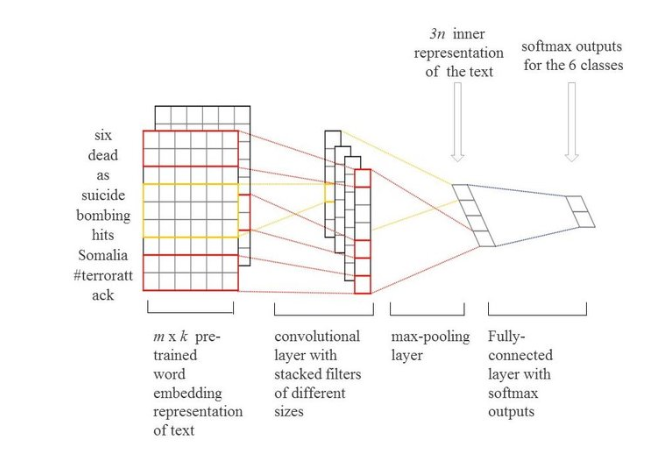

Vamos continuar utilizando uma amostra do dataset do IMDB traduzido para o português.

Este experimento foi baseado em https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9 .

In [ ]:
# Importação das bibliotecas

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/TopicosNLP-02_2022/Notebooks/Transformes/imdb-reviews-pt-br.csv.zip')

In [ ]:
df_pos=df[df.sentiment=='pos'].sample(5000, random_state=42)
df_neg=df[df.sentiment=='neg'].sample(5000, random_state=42)
df=pd.concat([df_pos,df_neg], ignore_index=True)
df.head()

,id,text_en,text_pt,sentiment
0,37528,ROLL is a wonderful little film. Toby Malone p...,ROLL é um pequeno filme maravilhoso. Toby Malo...,pos
1,44113,This is a great movie that I dont think gets e...,Este é um ótimo filme que eu acho que não rece...,pos
2,21351,The original story and funny compelling charac...,A história original e os personagens convincen...,pos
3,16267,I am very impressed by the reviews Ive read of...,Estou muito impressionado com os comentários q...,pos
4,45604,"Well, of course not, women are overly sensitiv...","Bem, claro que não, as mulheres são excessivam...",pos


In [ ]:
# Necessário replicar a descrição do sentimento para números inteiros
sentiment_to_code = {'neg':0, 'pos':1}
df.replace({'sentiment': sentiment_to_code}, inplace=True)

In [ ]:
# Separando os dados em treinamento e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text_pt,
                                                    df.sentiment,
                                                    test_size=0.2,
                                                    stratify=df.sentiment,
                                                    random_state=42)

docs=X_train
labels=y_train

In [ ]:
# O primeiro passo do pré-processamento é sempre a decodificação dos tokens
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

In [ ]:
# A segunda etapa é o de padding, etapa que possibilita a redução da 
# dimensionalidade do modelo conforme necessidade

encoded_docs = t.texts_to_sequences(docs)
max_length = 500
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

cnnmodel = Sequential()
cnnmodel.add(Embedding(vocab_size, 50, input_length=max_length))
# Foi adicionada uma camada de Dropout
cnnmodel.add(Dropout(0.2))
# Primeira camada de convolução
cnnmodel.add(Conv1D(50, 3, padding='same', activation='relu'))
cnnmodel.add(Dropout(0.4))
cnnmodel.add(MaxPooling1D())
cnnmodel.add(Flatten())
cnnmodel.add(Dense(250, activation='relu'))
cnnmodel.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compilação do modelo
cnnmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnnmodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 50)           2980900   
                                                                 
 dropout_10 (Dropout)        (None, 500, 50)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 500, 50)           7550      
                                                                 
 dropout_11 (Dropout)        (None, 500, 50)           0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 250, 50)          0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 12500)             0         
                                                      

In [ ]:
# Treinamento do modelo
cnnmodel.fit(padded_docs, labels, epochs=10, verbose=1)

Epoch 1/10
250/250 [==============================] - 2s 6ms/step - loss: 0.5951 - accuracy: 0.6429
Epoch 2/10
250/250 [==============================] - 2s 6ms/step - loss: 0.2140 - accuracy: 0.9161
Epoch 3/10
250/250 [==============================] - 2s 6ms/step - loss: 0.0388 - accuracy: 0.9894
Epoch 4/10
250/250 [==============================] - 2s 7ms/step - loss: 0.0059 - accuracy: 0.9990
Epoch 5/10
250/250 [==============================] - 2s 7ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 6/10
250/250 [==============================] - 1s 6ms/step - loss: 3.2289e-04 - accuracy: 1.0000
Epoch 7/10
250/250 [==============================] - 1s 6ms/step - loss: 1.5383e-04 - accuracy: 1.0000
Epoch 8/10
250/250 [==============================] - 1s 6ms/step - loss: 7.2596e-05 - accuracy: 1.0000
Epoch 9/10
250/250 [==============================] - 1s 6ms/step - loss: 4.4627e-05 - accuracy: 1.0000
Epoch 10/10
250/250 [==============================] - 1s 6ms/step - loss: 4.1364e-0

In [ ]:
# Verificação da acurácia utilizando os dados de teste
encoded_docs_test = t.texts_to_sequences(X_test)
max_length = 500
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

loss, accuracy = cnnmodel.evaluate(padded_docs_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 86.949998


## Usando uma rede recorrente (RNN) (fonte: https://towardsai.net/p/deep-learning/text-classification-with-rnn)

In [ ]:
from keras.layers import LSTM
from keras.layers.convolutional import MaxPooling1D

rnnmodel = Sequential()
rnnmodel.add(Embedding(vocab_size, 50, input_length=max_length))
rnnmodel.add(LSTM(100))
rnnmodel.add(Dense(1, activation='sigmoid'))

In [ ]:
rnnmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnnmodel.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 2000, 50)          2313650   
                                                                 
 lstm_2 (LSTM)               (None, 100)               60400     
                                                                 
 dense_26 (Dense)            (None, 1)                 101       
                                                                 
Total params: 2,374,151
Trainable params: 2,374,151
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
rnnmodel.fit(padded_docs, labels, epochs=10, verbose=1)

Epoch 1/10
250/250 [==============================] - 17s 64ms/step - loss: 0.6936 - accuracy: 0.4992
Epoch 2/10
250/250 [==============================] - 16s 65ms/step - loss: 0.6933 - accuracy: 0.4975
Epoch 3/10
250/250 [==============================] - 16s 63ms/step - loss: 0.6933 - accuracy: 0.4960
Epoch 4/10
250/250 [==============================] - 16s 63ms/step - loss: 0.6932 - accuracy: 0.4950
Epoch 5/10
250/250 [==============================] - 16s 65ms/step - loss: 0.6933 - accuracy: 0.4893
Epoch 6/10
250/250 [==============================] - 16s 64ms/step - loss: 0.6932 - accuracy: 0.4893
Epoch 7/10
250/250 [==============================] - 16s 63ms/step - loss: 0.6932 - accuracy: 0.4978
Epoch 8/10
250/250 [==============================] - 16s 63ms/step - loss: 0.6932 - accuracy: 0.4947
Epoch 9/10
250/250 [==============================] - 16s 65ms/step - loss: 0.6932 - accuracy: 0.4918
Epoch 10/10
250/250 [==============================] - 16s 63ms/step - loss: 0.693

In [ ]:
encoded_docs_test = t.texts_to_sequences(X_test)
max_length = 2000
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

loss, accuracy = rnnmodel.evaluate(padded_docs_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 50.000000


As arquiteturas RNN não são boas para classificação de texto

Outro experimento, melhorando o corpus, normalizando.

In [ ]:
stopwords = nltk.corpus.stopwords.words('portuguese')

def sentence_tokenizer(sentence):
  return [token.lemma_ for token in nlp(unidecode(sentence).lower()) 
              if (token.is_alpha & (str(token) not in stopwords))]

def sentence_normalizer(sentence):
  return ' '.join(sentence_tokenizer(sentence))

In [ ]:
sentiment_to_code = {'neg':0, 'pos':1}
df.replace({'sentiment': sentiment_to_code}, inplace=True)

In [ ]:
df.shape

(10000, 4)

In [ ]:
df.text_pt = df.text_pt.apply(sentence_normalizer)

In [ ]:
df.text_pt

0       nathan detroit frank sinatra gerente jogo flut...
1       the Good earth otimo filme todo mundo dever ve...
2       ler comentario fazer sobre filme atualmente po...
3       excelente filme sobre muito coisa busca serial...
4       vez ano vir filme tornar coisa facel voce voce...
                              ...                        
9995    fiquei impressionado cinderella jungle bookr p...
9996    dolph lundgren Estrela Murray Wilson alcoolatr...
9997    perdi bastante tempo verdade assistir tarefa f...
9998    nunca entendi apelo de este show atuacao pobre...
9999    contrario titulo filme nao oferecer tempero po...
Name: text_pt, Length: 10000, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text_pt,
                                                    df.sentiment,
                                                    test_size=0.2,
                                                    stratify=df.sentiment)

docs=X_train
labels=y_train

In [ ]:
# integer encode the documents
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

In [ ]:
vocab_size

46273

In [ ]:
# pad documents to a max length of  words
encoded_docs = t.texts_to_sequences(docs)
max_length = 2000
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

cnnmodel = Sequential()
cnnmodel.add(Embedding(vocab_size, 50, input_length=max_length))
model.add(Dropout(0.2))
cnnmodel.add(Conv1D(50, 3, padding='same', activation='relu'))
model.add(Dropout(0.2))
cnnmodel.add(MaxPooling1D())
cnnmodel.add(Flatten())
cnnmodel.add(Dense(250, activation='relu'))
cnnmodel.add(Dense(1, activation='sigmoid'))

cnnmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnnmodel.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 2000, 50)          2313650   
                                                                 
 conv1d_6 (Conv1D)           (None, 2000, 50)          7550      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1000, 50)         0         
 1D)                                                             
                                                                 
 flatten_16 (Flatten)        (None, 50000)             0         
                                                                 
 dense_24 (Dense)            (None, 250)               12500250  
                                                                 
 dense_25 (Dense)            (None, 1)                 251       
                                                     

In [ ]:
# fit the model
cnnmodel.fit(padded_docs, labels, epochs=50, verbose=1)

Epoch 1/50
250/250 [==============================] - 3s 10ms/step - loss: 5.0722e-05 - accuracy: 1.0000
Epoch 2/50
250/250 [==============================] - 3s 10ms/step - loss: 3.8907e-05 - accuracy: 1.0000
Epoch 3/50
250/250 [==============================] - 2s 10ms/step - loss: 3.0274e-05 - accuracy: 1.0000
Epoch 4/50
250/250 [==============================] - 3s 10ms/step - loss: 2.4089e-05 - accuracy: 1.0000
Epoch 5/50
250/250 [==============================] - 2s 10ms/step - loss: 1.9350e-05 - accuracy: 1.0000
Epoch 6/50
250/250 [==============================] - 2s 10ms/step - loss: 1.5725e-05 - accuracy: 1.0000
Epoch 7/50
250/250 [==============================] - 2s 10ms/step - loss: 1.2901e-05 - accuracy: 1.0000
Epoch 8/50
250/250 [==============================] - 2s 10ms/step - loss: 1.0115e-05 - accuracy: 1.0000
Epoch 9/50
250/250 [==============================] - 2s 10ms/step - loss: 6.9694e-06 - accuracy: 1.0000
Epoch 10/50
250/250 [==============================] - 

In [ ]:
encoded_docs_test = t.texts_to_sequences(X_test)
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

loss, accuracy = cnnmodel.evaluate(padded_docs_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 85.699999


In [ ]:
teste = pd.read_csv('/content/drive/MyDrive/TopicosNLP-02_2022/Notebooks/Transformes/imdb-reviews-pt-br.csv.zip')

In [ ]:
encoded_doc=t.texts_to_sequences([teste.iloc[300].text_pt])
padded_doc = pad_sequences(encoded_doc, maxlen=max_length, padding='post')

In [ ]:
padded_doc

array([[ 18,   5, 881, ...,   0,   0,   0]], dtype=int32)

In [ ]:
len(padded_doc)

1

In [ ]:
prediction = model.predict(padded_doc)
print(prediction)

1/1 [==============================] - 0s 16ms/step
[[0.36387813]]
